<img src='img/untappd-vector-logo.png' width='200px' style="float: right;">

# Untappd check-ins analisys
In this notebook I'm going get all my Untappd checkins with the help of Untappd API, some additional info using web scraping, analize it and build a model to try to predict rating I will give to a beer based on its parameters.

Data obtained in this notebook is available on Kaggle: https://www.kaggle.com/gruntoff/untappd-checkins

## What is Untappd
Untappd is a geosocial networking service and mobile phone application founded by Greg Avola and Tim Mather that allows its users to check in as they drink beers, and share these check-ins and their locations with their friends.

Untappd provides a platform for users to rate the beer they are consuming, earn badges, share pictures of their beers, review tap lists from nearby venues, see what beers their friends are drinking, comment on checked-in beers, and ask the app to suggest similar beverages.

## Getting data
First of all you need to get API key: https://untappd.com/api/register?register=new. <br> Your request could be processed a couple of weeks. As soon as we have it, we can start.

In [705]:
import untappd
import pandas as pd
import numpy as np
import requests
import json
import time
import datetime

from urllib.error import HTTPError
import urllib
from urllib.request import *

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

### Setting up API client

In [ ]:
client_id = # Untappd client id
client_secret = # Untappd secret
redirect_url = # Untappd redirect url

def get_client():
    client = untappd.Untappd(client_id=client_id, client_secret=client_secret, redirect_url=redirect_url)
    auth_url = client.oauth.get_auth_url()
    print(auth_url)
    return client

This will print a link you need to click and then get code from request parameters.

In [ ]:
client = get_client()

### Getting access token and setting it to API client

In [ ]:
def set_token(client, code):
    url = f'https://untappd.com/oauth/authorize/?client_id={client_id}&client_secret={client_secret}&response_type=code&redirect_url={redirect_url}&code={code}'
    headers = {'User-Agent': 'Mozilla/6.0'}
    r = Request(url, headers=headers)
    response = urlopen(r).read()
    data = json.loads(response.decode("utf-8"))
    client.set_access_token(data['response']['access_token'])

code = # Code from redirect url
set_token(client, code)

### Getting all check-ins with Untappd API
Now the client is set up and we can get our check-ins.

In [ ]:
def get_all_checkins(username):
    all_checkins = []
    max_id = None
    while (True):
        checkins = client.user.checkins(username, max_id=max_id)
        max_id = checkins['response']['pagination']['max_id']
        all_checkins.extend(checkins['response']['checkins']['items'])
        if (not max_id): break
    return all_checkins

checkins = get_all_checkins('gruntoff')

Untappd checkins were returnd by API as a JSON, so we need to manipulate it, remove unnescesarry fields to get table data.

Now check-in data looks like this.

In [11]:
checkins[0]

{'checkin_id': 972632193,
 'created_at': 'Tue, 08 Dec 2020 19:09:24 +0000',
 'checkin_comment': '',
 'rating_score': 3.5,
 'user': {'uid': 1279815,
  'user_name': 'gruntoff',
  'first_name': 'Nikita',
  'last_name': 'Gruntov',
  'location': 'Miensk',
  'is_supporter': 0,
  'url': '',
  'bio': 'Beetlefield Home Brewery',
  'relationship': 'self',
  'user_avatar': 'https://untappd.akamaized.net/profile/39f6c746498b5a455bcee2d61193e886_100x100.jpg',
  'is_private': 0,
  'contact': {'facebook': '100001820536978', 'twitter': 'ngruntov'}},
 'beer': {'bid': 3059699,
  'beer_name': 'Session IPA',
  'beer_label': 'https://untappd.akamaized.net/site/beer_logos/beer-3059699_a969b_sm.jpeg',
  'beer_style': 'IPA - Session / India Session Ale',
  'beer_slug': 'grupo-mahou-san-miguel-session-ipa',
  'beer_abv': 4.5,
  'beer_active': 1,
  'has_had': True},
 'brewery': {'brewery_id': 4726,
  'brewery_name': 'Grupo Mahou-San Miguel',
  'brewery_slug': 'grupo-mahou-san-miguel',
  'brewery_page_url': '/Ma

### Creating Pandas dataframe and cleaning it

In [12]:
df = pd.DataFrame(checkins)

In [15]:
def preprocess_checkins(df):
    df['user_id'] = df['user'].apply(lambda x: x['uid'])
    df['user_name'] = df['user'].apply(lambda x: x['user_name'])

    df['beer_id'] = df['beer'].apply(lambda x: x['bid'])
    df['beer_name'] = df['beer'].apply(lambda x: x['beer_name'])
    df['beer_style'] = df['beer'].apply(lambda x: x['beer_style'])
    df['beer_slug'] = df['beer'].apply(lambda x: x['beer_slug'])
    df['beer_abv'] = df['beer'].apply(lambda x: x['beer_abv'])
    df['beer_link'] = df['beer'].apply(lambda x: 'https://untappd.com/b/%s/%d' % (x['beer_slug'], x['bid']))
    df['has_had'] = df['beer'].apply(lambda x: x['has_had'])

    df['brewery_id'] = df['brewery'].apply(lambda x: x['brewery_id'])
    df['brewery_name'] = df['brewery'].apply(lambda x: x['brewery_name'])
    df['brewery_type'] = df['brewery'].apply(lambda x: x['brewery_type'])
    df['brewery_country'] = df['brewery'].apply(lambda x: x['country_name'])
    df['brewery_city'] = df['brewery'].apply(lambda x: x['location']['brewery_city'])
    df['brewery_link'] = df['brewery'].apply(lambda x: 'https://untappd.com%s' % x['brewery_page_url'])
    
    df['source_app'] = df['source'].apply(lambda x: x['app_name'])
    
    df['toasts_count'] = df['toasts'].apply(lambda x: x['total_count'])
    
    df['venue_id'] = df['venue'].apply(lambda x: np.nan if not x else str(x['venue_id']))
    df['venue_name'] = df['venue'].apply(lambda x: np.nan if not x else x['venue_name'])
    df['venue_country'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['venue_country'])
    df['venue_city'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['venue_city'])
    df['venue_lat'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['lat'])
    df['venue_lng'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['lng'])
    
    df.drop(['user', 'beer', 'badges', 'brewery', 'toasts', 'comments', 'media', 'venue', 'source', 'has_had'], axis=1, inplace=True)

In [18]:
preprocess_checkins(df)
df.head()

,checkin_id,created_at,checkin_comment,rating_score,user_id,user_name,beer_id,beer_name,beer_style,beer_slug,...,brewery_city,brewery_link,source_app,toasts_count,venue_id,venue_name,venue_country,venue_city,venue_lat,venue_lng
0,972632193,"Tue, 08 Dec 2020 19:09:24 +0000",,3.50,1279815,gruntoff,3059699,Session IPA,IPA - Session / India Session Ale,grupo-mahou-san-miguel-session-ipa,...,Madrid,https://untappd.com/MahouSanMiguel,Untappd for iPhone - (V2),0,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
1,972225431,"Sun, 06 Dec 2020 21:49:46 +0000",,3.50,1279815,gruntoff,1707304,APA Vic Secret & Galaxy,Pale Ale - American,wolf-s-brewery-volkovskaya-pivovarnya-apa-vic-...,...,Moscow,https://untappd.com/WolfsBrewery,Untappd for iPhone - (V2),0,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
2,972224466,"Sun, 06 Dec 2020 21:48:07 +0000",З вядра! Нешта набрадзіла,0.00,1279815,gruntoff,4086494,Apathem,Pale Ale - American,beetlefield-apathem,...,Minsk,https://untappd.com/Beetlefield,Untappd for iPhone - (V2),1,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
3,971765224,"Sat, 05 Dec 2020 23:04:03 +0000",,4.00,1279815,gruntoff,4081564,Pavaloka: HBC 472,IPA - Triple New England,malanka-pavaloka-hbc-472,...,Minsk,https://untappd.com/Malanka,Untappd for iPhone - (V2),2,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
4,971635392,"Sat, 05 Dec 2020 20:51:22 +0000",,3.75,1279815,gruntoff,3979681,Banana Smoothie,Fruit Beer,zavod-banana-smoothie,...,Khimki,https://untappd.com/Zavodbrewery,Untappd for iPhone - (V2),1,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57


Now our data looks like this. Much better.

### Scraping using BeautifulSoup
Next I'd like to get some more data on beers from Untappd webside using web scraping. <br> We need **Number of check-ins**, **Number of ratings** and **Average rating**.

In [ ]:
def scrape_data(df, proxies):
    headers = {'User-Agent': 'Mozilla/6.0'}
    
    while (df.ratings_count.isna().sum() > 0):
        try:
            for index, row in df.iterrows():
                if pd.notna(row['ratings_count']):
                    continue
                link = row['beer_link']
                print(index, link)
                request = requests.get(link, headers=headers, proxies=proxies)
                html = request.text
                bs = BeautifulSoup(html, features='html.parser')
                avg_rat = parse_rating(bs.select_one('.num').string)
                rat_count = int(bs.select_one('.raters').string.strip().split(' ', 1)[0].replace(',', ''))
                check_count = parse_checkin_count(bs.select_one('.count').string)
                ibu = parse_ibu(bs.select_one('.ibu').string)
                df.loc[index, 'avg_rating'] = avg_rat
                df.loc[index, 'ratings_count'] = rat_count
                df.loc[index, 'checkins_count'] = check_count
        except HTTPError as e:
            print(e)
            time.sleep(60)

def create_columns(df):
    df[['avg_rating', 'ratings_count', 'checkins_count', 'beer_ibu']] = np.nan

def parse_rating(rating):
    try:
        return float(rating.strip('()'))
    except:
        return np.nan

def parse_checkin_count(checkin):
    if ('M+' in checkin):
        return float(checkin.strip().replace('M+', '')) * 1000000
    return int(checkin.strip().replace(',', ''))

def parse_ibu(ibu):
    i = ibu.strip().split(' ', 1)[0]
    try:
        return int(i)
    except Exception as e:
        return 0  

In [422]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
proxies = {'http': 'http://172.67.181.9:80'} # Use working proxy server

In [ ]:
create_columns(df)
scrape_data(df, proxies)

Now we have full data. Let's see the first 5 rows.

In [472]:
df.head()

,checkin_id,created_at,checkin_comment,rating_score,user_id,user_name,beer_id,beer_name,beer_style,beer_slug,...,venue_id,venue_name,venue_country,venue_city,venue_lat,venue_lng,avg_rating,ratings_count,checkins_count,beer_ibu
0,972632193,2020-12-08 19:09:24+00:00,NaN,3.50,1279815,gruntoff,3059699,Session IPA,IPA - Session / India Session Ale,grupo-mahou-san-miguel-session-ipa,...,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,3.28,8755.0,10789.0,40.0
1,972225431,2020-12-06 21:49:46+00:00,NaN,3.50,1279815,gruntoff,1707304,APA Vic Secret & Galaxy,Pale Ale - American,wolf-s-brewery-volkovskaya-pivovarnya-apa-vic-...,...,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,3.48,3078.0,3960.0,27.0
2,971765224,2020-12-05 23:04:03+00:00,NaN,4.00,1279815,gruntoff,4081564,Pavaloka: HBC 472,IPA - Triple New England,malanka-pavaloka-hbc-472,...,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,4.33,71.0,93.0,0.0
3,971635392,2020-12-05 20:51:22+00:00,NaN,3.75,1279815,gruntoff,3979681,Banana Smoothie,Fruit Beer,zavod-banana-smoothie,...,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,4.16,486.0,543.0,0.0
4,971607921,2020-12-05 20:25:44+00:00,NaN,3.75,1279815,gruntoff,2609130,Good Times Coming,IPA - Milkshake,mad-frog-brewery-good-times-coming,...,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,3.91,397.0,485.0,35.0


### Save data to csv file

In [450]:
df.to_csv('checkins.csv', index=False)

<br>
<br>

## Take a look at our data 

#### All columns

In [37]:
pd.DataFrame(df.columns)

,0
0,checkin_id
1,created_at
2,checkin_comment
3,rating_score
4,user_id
5,user_name
6,beer_id
7,beer_name
8,beer_style
9,beer_slug


### Important data that we have

|Column name      | Description                             |
|-----------------|-----------------------------------------|
| created_at      | Date and time of check-in               |
| rating_score    | My rating for this beer                 |
| beer_name       | Beer name                               |
| beer_style      | Beers style                             |
| beer_abv        | Beer alcohol by volume                  |
| beer_ibu        | International Bittering Units           |
| brewery_name    | Brewery name                            |
| brewery_type    | Brewery type (nano, micro, macro, etc.) |
| brewery_country | Brewery country                         |
| venue_name      | Name of the venue                       |
| avg_rating      | Average rating of this beer             |
| ratings_count   | Number of ratings of this beer          |
| checkins_count  | Number of check-ins of this beer        |



In [27]:
df.describe()

,checkin_id,rating_score,user_id,beer_id,beer_abv,brewery_id,toasts_count,venue_id,venue_lat,venue_lng,avg_rating,ratings_count,checkins_count
count,2.727000e+03,2727.000000,2727.0,2.727000e+03,2727.000000,2727.000000,2727.000000,2.715000e+03,2715.000000,2715.000000,2697.000000,2727.000000,2.727000e+03
mean,7.752371e+08,3.505684,1279815.0,2.702195e+06,5.742765,207718.162450,0.946461,7.220315e+06,54.016850,27.219604,3.786515,10998.596993,2.595830e+04
std,1.312709e+08,0.888948,0.0,1.121409e+06,1.647205,152149.329606,0.966076,2.256592e+06,1.322132,5.909141,0.358633,63697.401530,1.985698e+05
min,4.400218e+08,0.000000,1279815.0,7.500000e+01,0.000000,5.000000,0.000000,7.229400e+04,34.234700,-77.948200,2.060000,0.000000,1.000000e+00
25%,6.742378e+08,3.250000,1279815.0,2.228658e+06,4.800000,44976.000000,0.000000,5.831627e+06,53.889500,27.553600,3.580000,192.000000,2.180000e+02
50%,7.878380e+08,3.750000,1279815.0,3.079866e+06,5.500000,237503.000000,1.000000,8.130117e+06,53.905300,27.569700,3.840000,411.000000,4.850000e+02
75%,8.970508e+08,4.000000,1279815.0,3.514315e+06,6.500000,329172.000000,1.000000,8.794204e+06,53.915000,27.575600,4.050000,1414.500000,1.656500e+03
max,9.726322e+08,4.750000,1279815.0,4.086494e+06,22.000000,481915.000000,5.000000,1.027480e+07,59.450400,37.625100,4.730000,692439.000000,2.430000e+06


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2727 entries, 0 to 2726
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   checkin_id       2727 non-null   int64  
 1   created_at       2727 non-null   object 
 2   checkin_comment  301 non-null    object 
 3   rating_score     2727 non-null   float64
 4   user_id          2727 non-null   int64  
 5   user_name        2727 non-null   object 
 6   beer_id          2727 non-null   int64  
 7   beer_name        2727 non-null   object 
 8   beer_style       2727 non-null   object 
 9   beer_slug        2727 non-null   object 
 10  beer_abv         2727 non-null   float64
 11  beer_link        2727 non-null   object 
 12  brewery_id       2727 non-null   int64  
 13  brewery_name     2727 non-null   object 
 14  brewery_type     2727 non-null   object 
 15  brewery_country  2727 non-null   object 
 16  brewery_city     2473 non-null   object 
 17  brewery_link  

Zero rating means check-in is unscored. Let's check number of unscored check-ins.

In [61]:
unscored = df[df["rating_score"] == 0]
f'Unscored check-ins: {len(unscored)}'

'Unscored check-ins: 109'

There are 109 check-ins without rating. Let's drop them.

In [490]:
df.drop(unscored.index.to_list(), inplace=True)
df.reset_index(drop=True, inplace=True)

## Data visualization
Let's plot some graphs to get some insights from data.

### Distributions

First of all let's wee how my ratings are distributed.

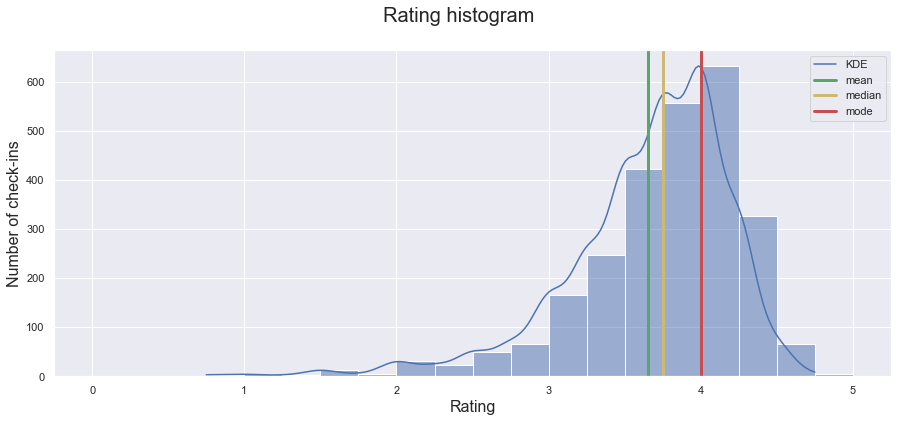

In [231]:
plt.figure(figsize=(15,6))
figure = sns.histplot(x='rating_score', data=df, bins=np.linspace(0, 5, 21), kde=True)
plt.axvline(x=df['rating_score'].mean(), linewidth=3, color='g', label="mean")
plt.axvline(x=df['rating_score'].median(), linewidth=3, color='y', label="median")
plt.axvline(x=df['rating_score'].mode()[0], linewidth=3, color='r', label="mode")

plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Rating', fontsize=16)
plt.suptitle('Rating histogram', fontsize=20)
plt.legend(['KDE', 'mean', 'median', 'mode'])
plt.show()

On this histogram we can see, that my rating distribution has negative skew, as mode is greater than mean and median.

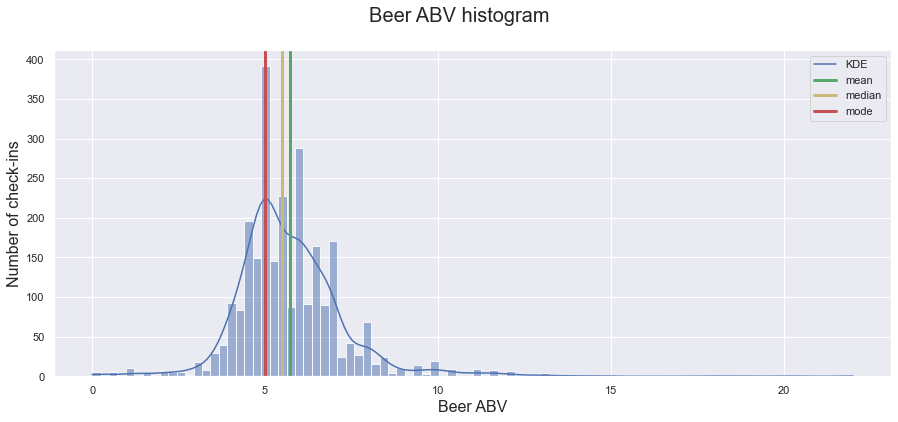

In [179]:
plt.figure(figsize=(15,6))
figure = sns.histplot(x='beer_abv', data=df, kde=True)
plt.axvline(x=df['beer_abv'].mean(), linewidth=3, color='g', label="mean")
plt.axvline(x=df['beer_abv'].median(), linewidth=3, color='y', label="median")
plt.axvline(x=df['beer_abv'].mode()[0], linewidth=3, color='r', label="mode")

plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Beer ABV', fontsize=16)
plt.suptitle('Beer ABV histogram', fontsize=20)
plt.legend(['KDE', 'mean', 'median', 'mode'])
plt.show()

Beer ABV distribution on the contrary has slight positive skew.

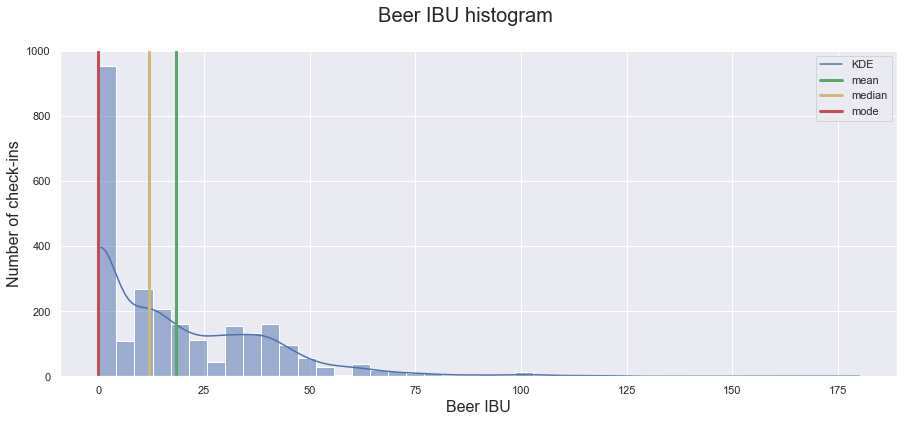

In [451]:
plt.figure(figsize=(15,6))
figure = sns.histplot(x='beer_ibu', data=df, kde=True)
plt.axvline(x=df['beer_ibu'].mean(), linewidth=3, color='g', label="mean")
plt.axvline(x=df['beer_ibu'].median(), linewidth=3, color='y', label="median")
plt.axvline(x=df['beer_ibu'].mode()[0], linewidth=3, color='r', label="mode")

plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Beer IBU', fontsize=16)
plt.suptitle('Beer IBU histogram', fontsize=20)
plt.legend(['KDE', 'mean', 'median', 'mode'])
plt.show()

### Most popular
Now I want to find out what are the most popular beers, breweries, etc.

In [357]:
# function for horizontal countplot
def hcountplot(data, y, xlabel, ylabel, suptitle, order=None):
    plt.figure(figsize=(15,6))
    figure = sns.countplot(y=y, data=data, order=order)
    plt.ylabel(ylabel, fontsize=20) 
    plt.xlabel(xlabel, fontsize=20)
    plt.suptitle(suptitle, fontsize=26)
    plt.show()

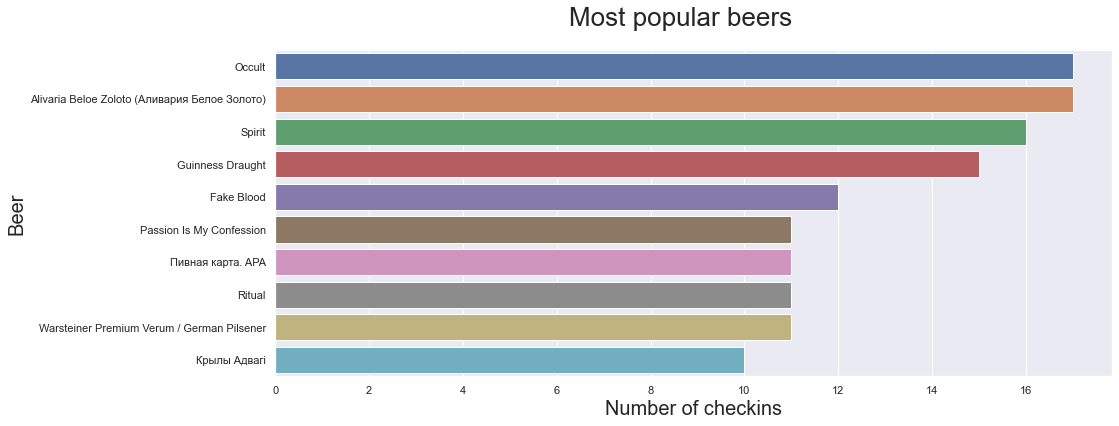

In [487]:
hcountplot(df, 'beer_name', 'Number of checkins', 'Beer', 
           'Most popular beers', df['beer_name'].value_counts().iloc[:10].index)

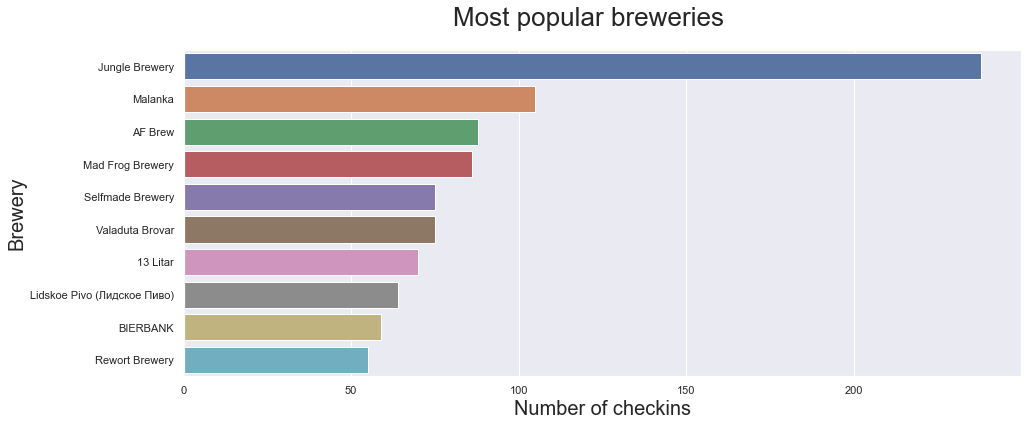

In [368]:
hcountplot(df, 'brewery_name', 'Number of checkins', 'Brewery', 
           'Most popular breweries', df['brewery_name'].value_counts().iloc[:10].index)

**Jungle Brewery** is a local craft brewery from Minsk, Belarus where I live. They brew a new beer every couple of weeks and it's always on tap almost in every bar. And besides they a making great brews! So it's no surprise.

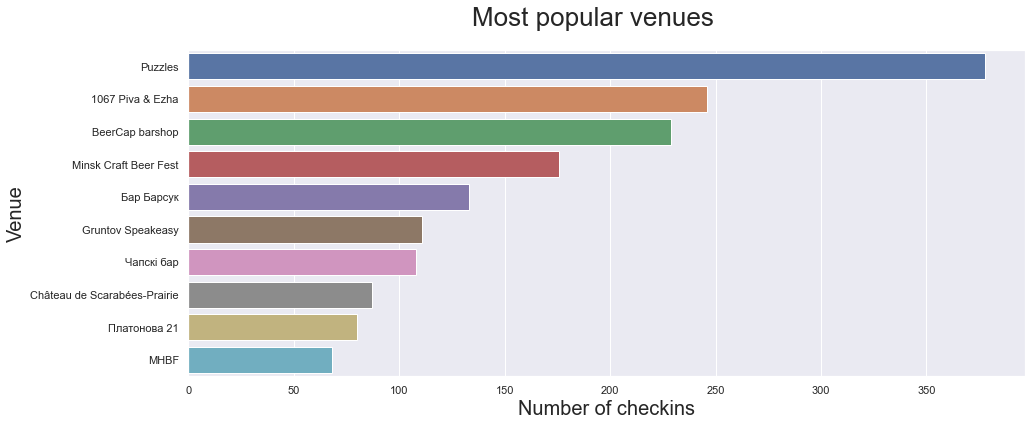

In [369]:
hcountplot(df, 'venue_name', 'Number of checkins', 'Venue', 
           'Most popular venues', df['venue_name'].value_counts().iloc[:10].index)

Most popular venue is **Puzzles**. It's a location for my home. So again no surprise.

Now let's take a look at beer styles.

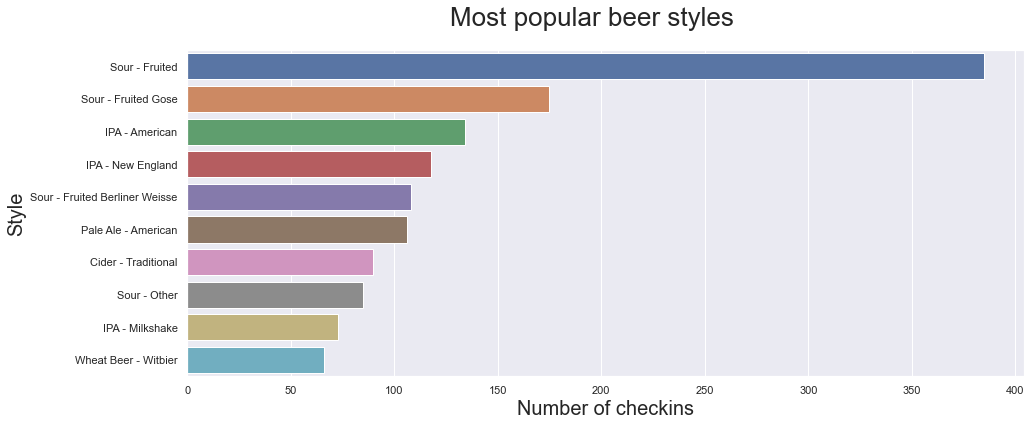

In [362]:
hcountplot(df, 'beer_style', 'Number of checkins', 'Style',  
           'Most popular beer styles', df['beer_style'].value_counts().iloc[:10].index)

As we see, sour styles dominate and **Sour-Fruited** leads by a huge margin.

And now we'll look at general styles.

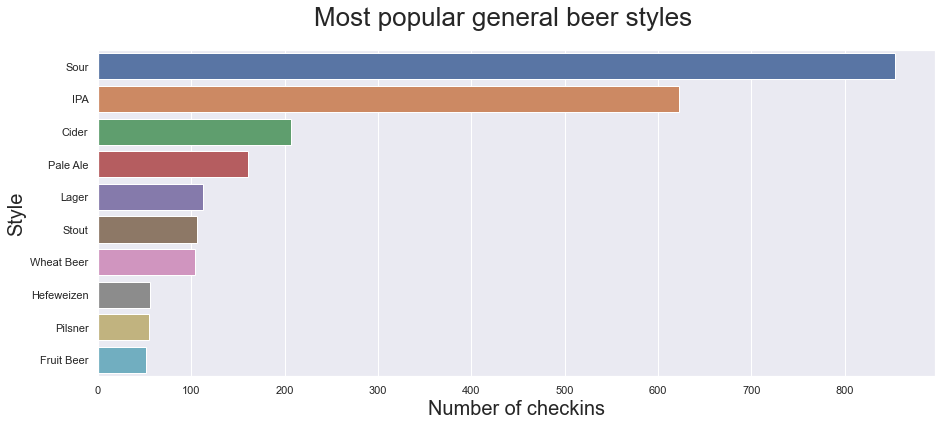

In [363]:
general_styles = df['beer_style'].str.split('-').map(lambda x: x[0].strip())
hcountplot(df, general_styles, 'Number of checkins', 'Style', 
           'Most popular general beer styles', general_styles.value_counts().iloc[:10].index)

**Sour** still leads, but not by so much. **IPA** reduced the gap thanks to a large number of substyles.


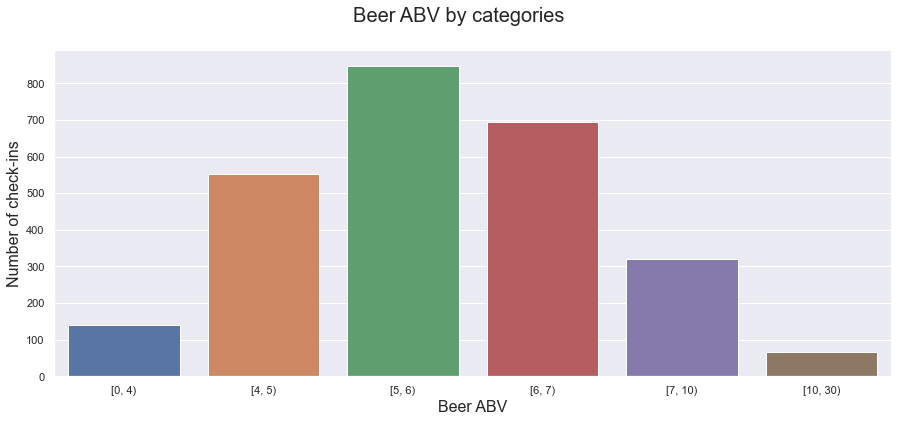

In [180]:
abv_cat = pd.cut(df['beer_abv'], bins=[0, 4, 5, 6, 7, 10, 30], right=False, 
       labels=['[0, 4)', '[4, 5)', '[5, 6)', '[6, 7)', '[7, 10)', '[10, 30)'])
plt.figure(figsize=(15,6))
figure = sns.countplot(x=abv_cat)
plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Beer ABV', fontsize=16)
plt.suptitle('Beer ABV by categories', fontsize=20)
plt.show()

The most popular beer ABV category is [5, 6) % ABV.

### Highest rated

And which beer styles are the highest rated?
We will take only beer styles with at least 10 different beers checked-in.

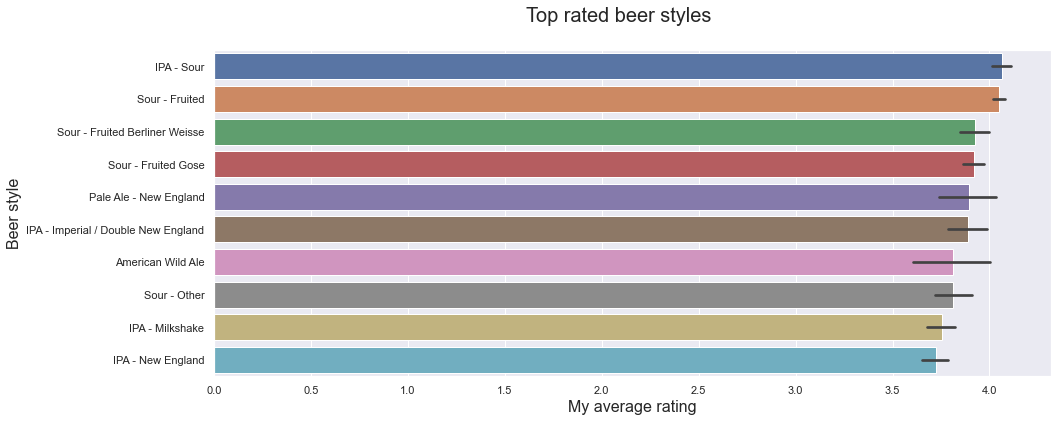

In [364]:
filtered = df.groupby('beer_style').filter(lambda x: x['beer_id'].nunique() >= 10)
plt.figure(figsize=(15,6))
plot_order = filtered.groupby('beer_style')['rating_score'].mean().sort_values(ascending=False).iloc[:10].index
figure = sns.barplot(y='beer_style', x='rating_score', data=filtered, order=plot_order)
plt.ylabel('Beer style', fontsize=16) 
plt.xlabel('My average rating', fontsize=16)
plt.suptitle('Top rated beer styles', fontsize=20)
plt.show()

**IPA-Sour** has the highest average rating. **Sour-Fruited** is second, narrowly defeated.

Highest rated breweries are also important. Let's look at breweries with at least 10 distinct beers checked in.

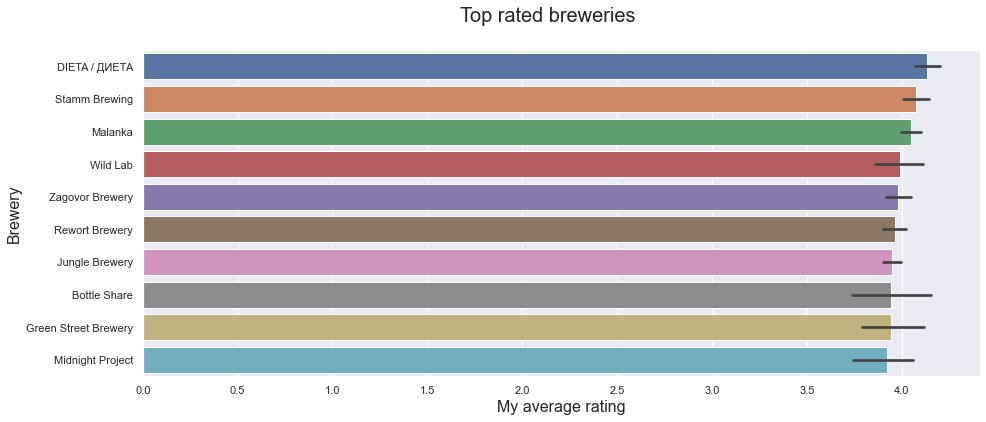

In [491]:
filtered = df.groupby('brewery_name').filter(lambda x: x['beer_id'].nunique() >= 10)
plt.figure(figsize=(15,6))
plot_order = filtered.groupby('brewery_name')['rating_score'].mean().sort_values(ascending=False).iloc[:10].index
figure = sns.barplot(y='brewery_name', x='rating_score', data=filtered, order=plot_order)
plt.ylabel('Brewery', fontsize=16) 
plt.xlabel('My average rating', fontsize=16)
plt.suptitle('Top rated breweries', fontsize=20)
plt.show()

### Corellations
Also I'm interested to see if there are corellations between my rating and other features.

In [494]:
df.corr()

,checkin_id,rating_score,user_id,beer_id,beer_abv,brewery_id,toasts_count,venue_id,venue_lat,venue_lng,avg_rating,ratings_count,checkins_count,beer_ibu
checkin_id,1.000000,0.319559,NaN,0.473702,0.119559,0.271525,0.240718,0.456333,-0.074780,-0.048797,0.274974,-0.055713,-0.044205,-0.096442
rating_score,0.319559,1.000000,NaN,0.322976,0.155021,0.245729,0.242935,0.127863,-0.013170,0.002082,0.583595,-0.010090,0.006338,-0.072220
user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beer_id,0.473702,0.322976,NaN,1.000000,0.221544,0.590768,0.287836,0.345008,-0.088768,0.016632,0.550819,-0.377620,-0.300930,0.005977
beer_abv,0.119559,0.155021,NaN,0.221544,1.000000,0.188491,0.079182,0.103862,-0.026910,0.019400,0.392661,-0.104092,-0.093048,0.297070
brewery_id,0.271525,0.245729,NaN,0.590768,0.188491,1.000000,0.372138,0.189594,-0.074072,0.009307,0.507630,-0.220597,-0.173014,0.049018
toasts_count,0.240718,0.242935,NaN,0.287836,0.079182,0.372138,1.000000,0.153392,-0.055949,0.026072,0.271593,-0.068243,-0.054022,0.025703
venue_id,0.456333,0.127863,NaN,0.345008,0.103862,0.189594,0.153392,1.000000,-0.173353,-0.041998,0.177541,-0.137347,-0.124675,-0.074246
venue_lat,-0.074780,-0.013170,NaN,-0.088768,-0.026910,-0.074072,-0.055949,-0.173353,1.000000,0.760245,-0.078652,0.012613,0.003833,-0.045560
venue_lng,-0.048797,0.002082,NaN,0.016632,0.019400,0.009307,0.026072,-0.041998,0.760245,1.000000,0.031519,0.007083,0.007591,0.012273


The only significant corellation is to Average rating.

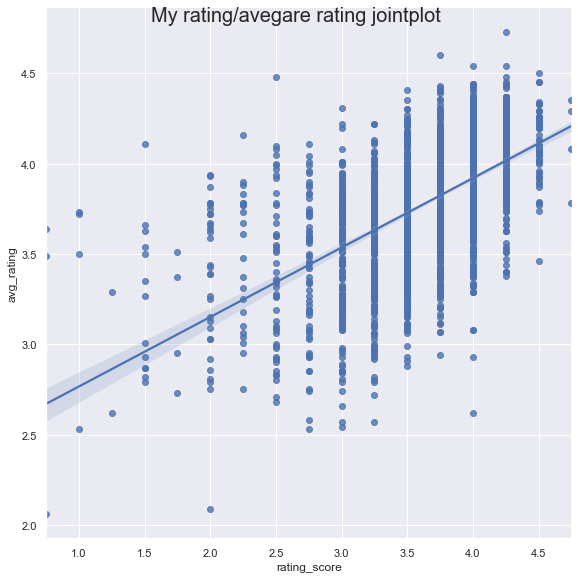

In [194]:
sns.lmplot(y='avg_rating', x='rating_score', data=df, height=8)
plt.suptitle('My rating/avegare rating jointplot', fontsize=20)
plt.show()

On the plot above we can see, that there is small positive corelletion between my rating and average rating.

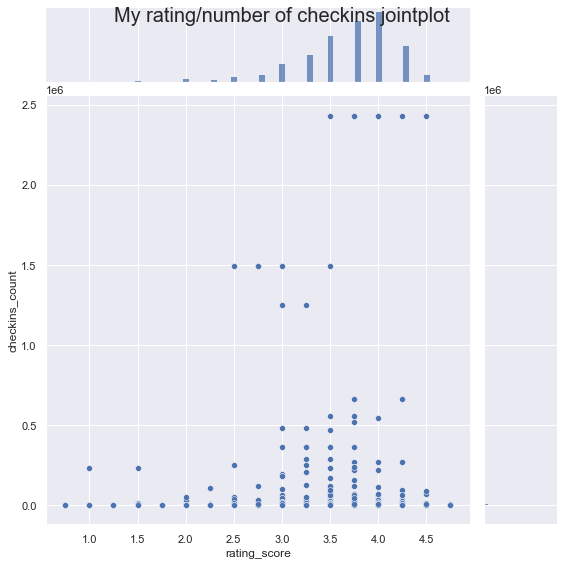

In [197]:
sns.jointplot(y='checkins_count', x='rating_score', data=df, height=8)
plt.suptitle('My rating/number of checkins jointplot', fontsize=20)
plt.show()

And on this plot we can see, that I almost never rate very bad beers with a large number of check-ins.

### Dates
Now I'm gonna convert created_at column to datetime and look at number of check-ins by weekday. Let's add 3 hours to get Minsk time. Almost all check-ins were made in timezone +03. It will be close enough.

In [542]:
df['created_at'] = pd.to_datetime(df['created_at'])
hours_added = datetime. timedelta(hours=3)
df['created_at'] = df['created_at'] + hours_added

In [543]:
wdays = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
            }
weekday = df['created_at'].apply(lambda x: x.weekday())
weekday = weekday.map(wdays)

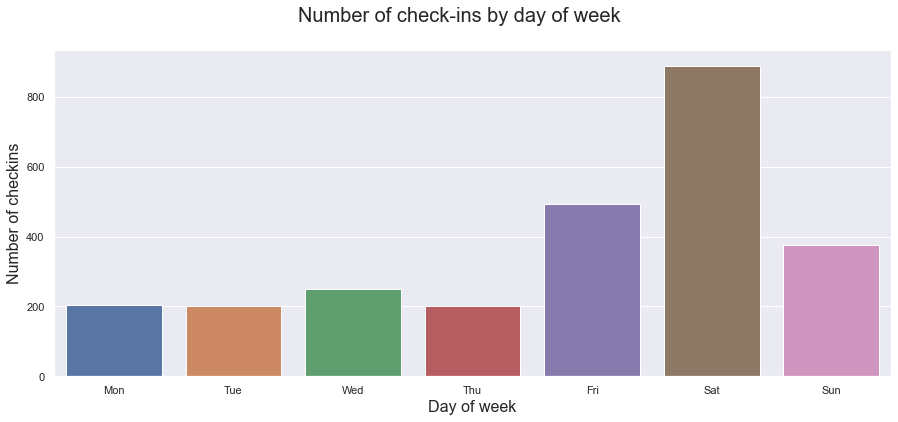

In [544]:
plt.figure(figsize=(15,6))
sns.countplot(x=weekday, order=wdays.values())
plt.ylabel('Number of checkins', fontsize=16) 
plt.xlabel('Day of week', fontsize=16)
plt.suptitle('Number of check-ins by day of week', fontsize=20)
plt.show()

Expectedly Saturday and Friday have the most number of check-ins. Also we can see on this graph, that "*Wednesday is a little Friday*".

Also it would be interesting to look at number of check-ins by day of month.

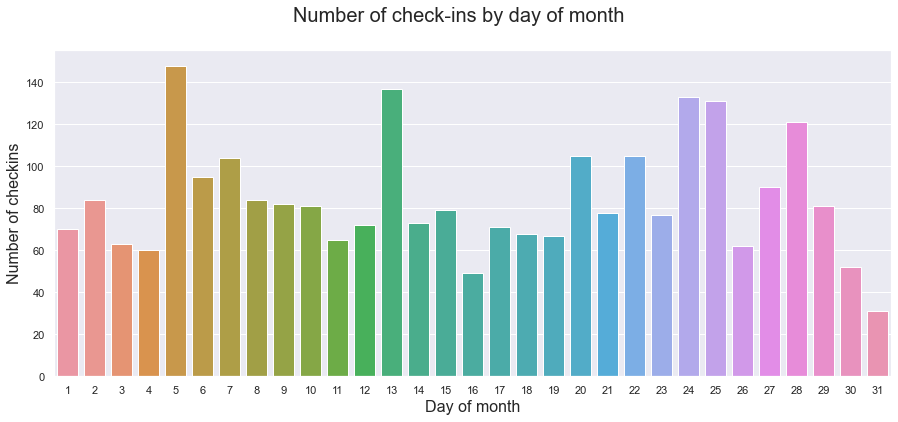

In [545]:
plt.figure(figsize=(15,6))
sns.countplot(x=df['created_at'].apply(lambda x: x.day))
plt.ylabel('Number of checkins', fontsize=16) 
plt.xlabel('Day of month', fontsize=16)
plt.suptitle('Number of check-ins by day of month', fontsize=20)
plt.show()


Here we see at least 4 peaks on 5th, 13th, 24th and 25th days. I think it could be connected to fests that were held on this days with a large number of check-ins. Let's check this.

In [546]:
fests_names = ['Minsk Craft Beer Fest', 'MHBF', 'Beer\'n\'Cider Fest']
fests = df[df['venue_name'].isin(fests_names)]
fest_dates = fests['created_at'].\
apply(lambda x: x.date).value_counts().rename_axis('date').reset_index(name='checkins')
fest_dates

,date,checkins
0,2019-10-05,67
1,2019-04-13,64
2,2019-08-24,39
3,2018-09-29,26
4,2019-05-25,24
5,2019-11-23,17
6,2018-04-21,15
7,2018-04-22,4


As I thought there were fests on these days.

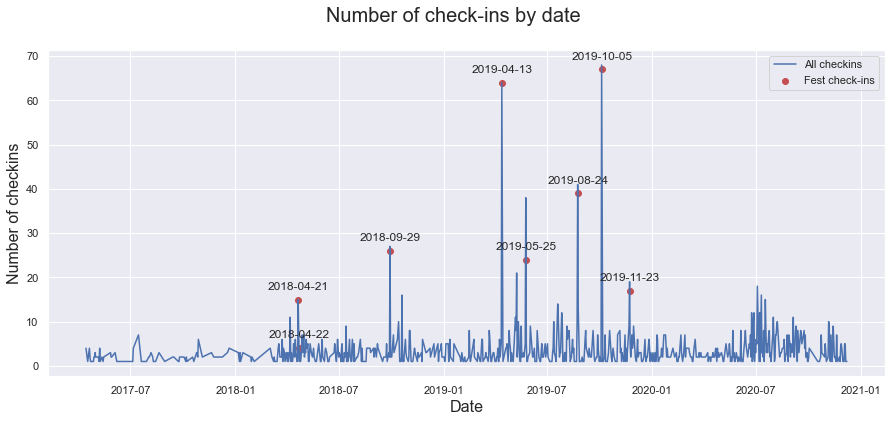

In [547]:
dates = df['created_at'].apply(
    lambda x: pd.to_datetime(x.date)).value_counts().rename_axis('date').reset_index(name='checkins')
plt.figure(figsize=(15,6))
sns.lineplot(data=dates, x='date', y='checkins')
plt.scatter(x=fest_dates['date'], y=fest_dates['checkins'], color='r')
for x,y in zip(fest_dates['date'],fest_dates['checkins']):
    plt.annotate(x, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylabel('Number of checkins', fontsize=16) 
plt.xlabel('Date', fontsize=16)
plt.suptitle('Number of check-ins by date', fontsize=20)
plt.legend(['All checkins', 'Fest check-ins'])
plt.show()

Fest days could be well seen on the graph above.

## Biulding a model

I would like to build a model that will predict my rating for a beer.
First of all let's drop columns containing all IDs, venue data, comment, and other unrelevant columns. We won't need it.

In [742]:
mdf = df.drop(columns=['checkin_id', 'checkin_comment', 'user_id', 'beer_id', 'venue_id', 'venue_name', 
                 'venue_country', 'beer_link', 'venue_city', 'venue_lng', 'venue_lat', 'brewery_id', 
                 'brewery_link', 'source_app', 'toasts_count', 'beer_name', 'user_name', 'beer_slug'])

In [743]:
mdf.head()

,created_at,rating_score,beer_style,beer_abv,brewery_name,brewery_type,brewery_country,brewery_city,avg_rating,ratings_count,checkins_count,beer_ibu
0,2020-12-08 22:09:24+00:00,3.50,IPA - Session / India Session Ale,4.5,Grupo Mahou-San Miguel,Macro Brewery,Spain,Madrid,3.28,8755.0,10789.0,40.0
1,2020-12-07 00:49:46+00:00,3.50,Pale Ale - American,5.5,Wolf's Brewery (Волковская Пивоварня),Micro Brewery,Russia,Moscow,3.48,3078.0,3960.0,27.0
2,2020-12-06 02:04:03+00:00,4.00,IPA - Triple New England,10.0,Malanka,Nano Brewery,Belarus,Minsk,4.33,71.0,93.0,0.0
3,2020-12-05 23:51:22+00:00,3.75,Fruit Beer,4.0,Zavod,Micro Brewery,Russia,Khimki,4.16,486.0,543.0,0.0
4,2020-12-05 23:25:44+00:00,3.75,IPA - Milkshake,6.4,Mad Frog Brewery,Nano Brewery,Belarus,Большое Стиклево,3.91,397.0,485.0,35.0


Splitting dataset into test and train and combining to manipulate easily.

In [744]:
X_train, X_test, y_train, y_test = \
train_test_split(mdf.drop(columns=['rating_score']), mdf['rating_score'], test_size=0.2, random_state=8)
combined = [X_train, X_test]

### Filling the missing data

In [745]:
for n in combined:
    n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 379 to 451
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       2094 non-null   datetime64[ns, UTC]
 1   beer_style       2094 non-null   object             
 2   beer_abv         2094 non-null   float64            
 3   brewery_name     2094 non-null   object             
 4   brewery_type     2094 non-null   object             
 5   brewery_country  2094 non-null   object             
 6   brewery_city     1892 non-null   object             
 7   avg_rating       2081 non-null   float64            
 8   ratings_count    2094 non-null   float64            
 9   checkins_count   2094 non-null   float64            
 10  beer_ibu         2094 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 196.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 524 entrie

We have missing data in *brewery_city*, *avg_rating*. Let's fill missing city with "Unknown" and missing rating with median rating.

In [746]:
for n in combined:
    n['brewery_city'] = n['brewery_city'].fillna('Unknown')
    n['avg_rating'] = n['avg_rating'].fillna(n['avg_rating'].median())

In [747]:
for n in combined:
    print(f'Missing values: {n.isna().sum().sum()}')

Missing values: 0
Missing values: 0


Great! There are no missing values now.

### Feature engineering
I'm going to build some new features out of existing ones.

Extracting weekday and hour from date and dropping it.

In [748]:
for n in combined:
    n['weekday'] = n['created_at'].apply(lambda x: x.weekday())
    n['hour'] = n['created_at'].apply(lambda x: x.hour)
    n.drop(columns=['created_at'], inplace=True)

Extracting general beer style.

In [749]:
for n in combined:
    n['general_style'] = n['beer_style'].str.split('-').map(lambda x: x[0].strip())

0 IBU mean either there are no IBU in this beer or it is unknown. We have a lot of zeros in our dataset. Lets make IBU categorical feature. 0 IBU will be Unknown. 1 to 20 UBU – Low. 21 to 40 – Medium. 41 to 60 – High. 61 and higher – Very high.

In [750]:
for n in combined:
    n['ibu_cat'] = pd.cut(n['beer_ibu'], bins=[-1, 0, 20, 40, 60, 200], 
                          labels=['Unknown', 'Low', 'Medium', 'High', 'Very high'])
    n.drop(columns=['beer_ibu'], inplace=True)

### Encoding categorical features

I'll use One hot encoder to encode categorical data.

In [774]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

### Training Random Forrest Regressor
Let's train a Random Forest Regressor using GridSearchCV.

In [752]:
from sklearn.metrics import mean_absolute_error, max_error

In [775]:
forest = RandomForestRegressor(oob_score=True, random_state=8)
params = {'n_estimators': [30, 50, 100], 'max_depth': [10, 50, 100], 'max_features': [0.1, 0.3, 0.5]}
clf = GridSearchCV(forest, params)

In [776]:
clf.fit(X_train_enc, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=8),
             param_grid={'max_depth': [10, 50, 100],
                         'max_features': [0.1, 0.3, 0.5],
                         'n_estimators': [30, 50, 100]})

In [777]:
print(f'Best RF parameters: {clf.best_params_}')

Best RF parameters: {'max_depth': 100, 'max_features': 0.1, 'n_estimators': 100}


In [778]:
print(f'OOB score = {clf.best_estimator_.oob_score_}')

OOB score = 0.41611545365400304


Untappd ratings have step 0.25, so I'll round predictions to 0.25.

In [779]:
def round025(x):
    return np.round(x*4)/4

pred = clf.best_estimator_.predict(X_test_enc)
rounded_pred = round025(pred)

In [780]:
pred[:10]

array([3.82864093, 3.9825    , 3.50954575, 3.95005155, 3.42589784,
       3.66953583, 3.995     , 3.58910354, 3.8175    , 3.81610163])

In [781]:
rounded_pred[:10]

array([3.75, 4.  , 3.5 , 4.  , 3.5 , 3.75, 4.  , 3.5 , 3.75, 3.75])

In [782]:
print(f'MAE = {mean_absolute_error(y_test, rounded_pred)}')
print(f'Max Error = {max_error(y_test, rounded_pred)}')
print(f'Exact ratings percentage = {sum(y_test.values == rounded_pred)/len(rounded_pred)}')

MSE = 0.26908396946564883
Max Error = 1.75
Exact ratings percentage = 0.3110687022900763


### Сonclusions

Using this simple model we managed to predict rating with MAE approximately equal to 1 step in Untappd rating. I think it's quite okay. The percentage of exact ratings is 31%. 

Some important features are missing for the model to perfom better. For example **Friends average rating** and **Serving style**.